<a href="https://colab.research.google.com/github/mmehmetaliyavuz/cellrecognation/blob/main/cellrecognation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!git clone https://github.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset.git /content/cell

fatal: destination path '/content/cell' already exists and is not an empty directory.


In [ ]:
!pip install keras_cv

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import keras_cv

Using TensorFlow backend


first of all we should give an eye to labels

In [ ]:
with open("/content/cell/Testing/Annotations/BloodImage_00339.xml","r") as files:
  print(files.read())

In [5]:
class_ids = [
    "Platelets",
    "RBC",
    "WBC"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
def create_data(pathDir):
  """
  path: path of folder which include Images and Annotations
  """
  pathDir= pathDir
  !mkdir -p "{pathDir}/new_annot"

  new_Images = pathDir+"/Images"
  new_Annot = pathDir+"/Annotations"
  import numpy as np
  import pandas as pd
  import xml.etree.ElementTree as ET
  import os
  path_annot = []
  path_images = []
  data_list = []
  def get_values(root, *args):
      filename = root.find('filename').text
      elements = [root]
      for tag in args:
          new_elements = []
          for element in elements:
              new_elements.extend(element.findall(tag))
          elements = new_elements
          if not elements:
              return None
      return [(element.find(name_variable).text,
              (int(element.find('bndbox').find('xmin').text),
                int(element.find('bndbox').find('ymin').text),
                int(element.find('bndbox').find('xmax').text),
                int(element.find('bndbox').find('ymax').text)),filename)
              for element in elements]

  name_variable = "name"  # Variable representing the tag name for object names

  with open("/content/cell/Testing/Annotations/BloodImage_00339.xml", "r") as files:
      xml_data = files.read()

  root = ET.fromstring(xml_data)
  objects = get_values(root, "object")


  def gets_path(new_Annot,new_Images):
    for dirpath, dirnames, filenames in os.walk(new_Annot):
      for filename in filenames:
        pathA = os.path.join(dirpath, filename)
        path_annot.append(pathA)
    for dirpath, dirnames, filenames in os.walk(new_Images):
      for filename in filenames:
        pathI =  os.path.join(dirpath, filename)
        path_images.append(pathI)
      return path_annot,path_images
  path_annot, path_images = gets_path(new_Annot,new_Images)

  jsons = []


  #these two for loop to exract features

  for path in path_annot:
    with open(path, "r") as files:
      xml_data = files.read()
      jsons.append(xml_data)
  for xml_data, filepath in zip(jsons, path_annot):

    root = ET.fromstring(xml_data)
    lines=get_values(root,"object")
    for line in lines:
      kind,(xmin,ymin,xmax,ymax),filename = line

      data_dict = {
                  "imagepaths": filepath.replace("Annotations","Images").replace("xml","jpg"),
                  "filepaths": filepath ,
                  "filename": filename,
                  "type": kind,
                  "xmin": xmin,
                  "ymin": ymin,
                  "xmax": xmax,
                  "ymax": ymax
              }
      data_list.append(data_dict)
  data = pd.DataFrame(data_list)
  data["type"]=data["type"].astype('category').cat.codes


  grouped = data.groupby('filename')[['type','xmin', 'ymin', 'xmax', 'ymax']].apply(lambda x: x.values.tolist())
  for filename, group in grouped.items():  # Accessing both filename and group
      with open(f"{pathDir}/new_annot/{filename.replace('jpg', 'txt')}", 'w') as f:
          for item in group:  # Iterating through the group
              line = ' '.join(map(str, item[:]))  # Convert item to string and join
              f.write(line + '\n')  # Write the line to the file
  return data

In [78]:
test_data = create_data("/content/cell/Testing")
train_data = create_data("/content/cell/Training")
valid_data = create_data("/content/cell/Validation")

In [9]:
def visualizer(data,column):
  """
  data: dataframe output of the create dataframe files
  column: which column want to be taken
  """
  img_col = data.iloc[column,:]
  same_img = data['filename'] == img_col["filename"]
  image = data[same_img]
  imagepath = data["imagepaths"][column]
  Image = cv2.imread(imagepath)
  for i in range(len(image)):
    cell = image.iloc[i,:]
    xmin,ymin,xmax,ymax =  cell["xmin"],cell["ymin"],cell["xmax"],cell["ymax"]
    kind = cell["type"]

    cv2.rectangle(Image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(Image, class_mapping[kind], (xmin, ymin -4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
  cv2_imshow(Image)
  return

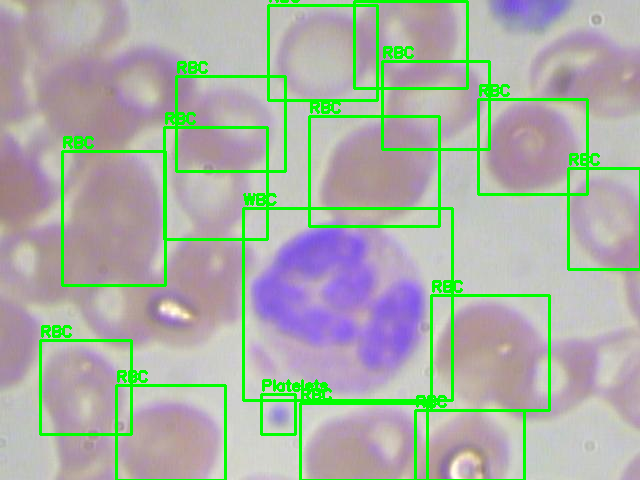

In [10]:
visualizer(train_data,100)

In [43]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img,channels = 3)
    img = tf.cast(img, tf.float32)
    return img
jittered_resize = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy",
)

def handler(img_paths, bbox, classes):
    image = load_image(img_paths)
    bboxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox}

    return {"images": image, "bounding_boxes": bboxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [100]:
def dataV8(data,annotpath):
  """
  data: dataframe output of create data
  annot: path for the new_annot folder
         example of annot pathway:'content/cell/Testing/new_annot'
  """
  image_paths = data["imagepaths"].to_numpy()
  path_annot = []

  def gets_path(annot):
      path_annot = []
      for dirpath, dirnames, filenames in os.walk(annot):
          for filename in filenames:
              pathA = os.path.join(dirpath, filename)
              path_annot.append(pathA)
      return path_annot

  annot_paths = gets_path(annotpath)
  bboxes = []
  classes = []
  sorted_annot_paths = np.array(annot_paths)[np.argsort([int(path.split('_')[-1].split('.')[0]) for path in annot_paths])]

  for annot_file in sorted_annot_paths:
    with open(annot_file, "r") as file_label:
        lines = file_label.read().split('\n')
        boxes = []
        classes_ = []
        for line in lines:
            if line.strip() and not line.startswith('<?xml'):  # Skip empty lines and XML declarations
                objbud = line.split(' ')
                class_ = int(objbud[0])
                xmin = float(objbud[1])
                ymin = float(objbud[2])
                xmax = float(objbud[3])
                ymax = float(objbud[4])
                boxes.append([xmin, ymin, xmax, ymax])
                classes_.append(class_)
        bboxes.append(boxes)
        classes.append(classes_)

  image_paths = list(set(image_paths))
  sorted_image_paths = np.array(image_paths)[np.argsort([int(path.split('_')[-1].split('.')[0]) for path in image_paths])]
  image_paths = tf.ragged.constant(np.array(sorted_image_paths))
  bboxes = tf.ragged.constant(bboxes)
  classes = tf.ragged.constant(classes)

  return image_paths, bboxes, classes


In [86]:
pathtest_annot = '/content/cell/Testing/new_annot'
test_paths, test_bboxes, test_classes= dataV8(test_data, pathtest_annot)
pathtrain_annot = '/content/cell/Training/new_annot'
train_paths, train_bboxes, train_classes= dataV8(test_data, pathtrain_annot)
pathvalid_annot = '/content/cell/Validation/new_annot'
valid_paths, valid_bboxes, valid_classes = dataV8(test_data, pathvalid_annot)

In [99]:
pathtrain_annot = '/content/cell/Training/new_annot'
train_paths, train_bboxes, train_classes = dataV8(train_data, pathtrain_annot)
pathvalid_annot = '/content/cell/Validation/new_annot'
valid_paths, valid_bboxes, valid_classes = dataV8(valid_data, pathvalid_annot)

In [89]:
test = tf.data.Dataset.from_tensor_slices((test_paths, test_bboxes, test_classes))
test_data = (test
             .map(handler, num_parallel_calls=tf.data.AUTOTUNE)
             .shuffle(40)
             .ragged_batch(4, drop_remainder=True)
             .map(jittered_resize, num_parallel_calls=tf.data.AUTOTUNE)
             .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
             .prefetch(tf.data.AUTOTUNE))

In [105]:
train = tf.data.Dataset.from_tensor_slices((train_paths, train_bboxes, train_classes))
train_data = (train
             .map(handler, num_parallel_calls=tf.data.AUTOTUNE)
             .shuffle(40)
             .ragged_batch(4, drop_remainder=True)
             .map(jittered_resize, num_parallel_calls=tf.data.AUTOTUNE)
             .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
             .prefetch(tf.data.AUTOTUNE))
valid = tf.data.Dataset.from_tensor_slices((valid_paths, valid_bboxes, valid_classes))
valid_data = (valid
             .map(handler, num_parallel_calls=tf.data.AUTOTUNE)
             .shuffle(40)
             .ragged_batch(4, drop_remainder=True)
             .map(jittered_resize, num_parallel_calls=tf.data.AUTOTUNE)
             .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
             .prefetch(tf.data.AUTOTUNE))

In [94]:
def visualizerV8(inputs, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        rows=2,
        cols=2,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

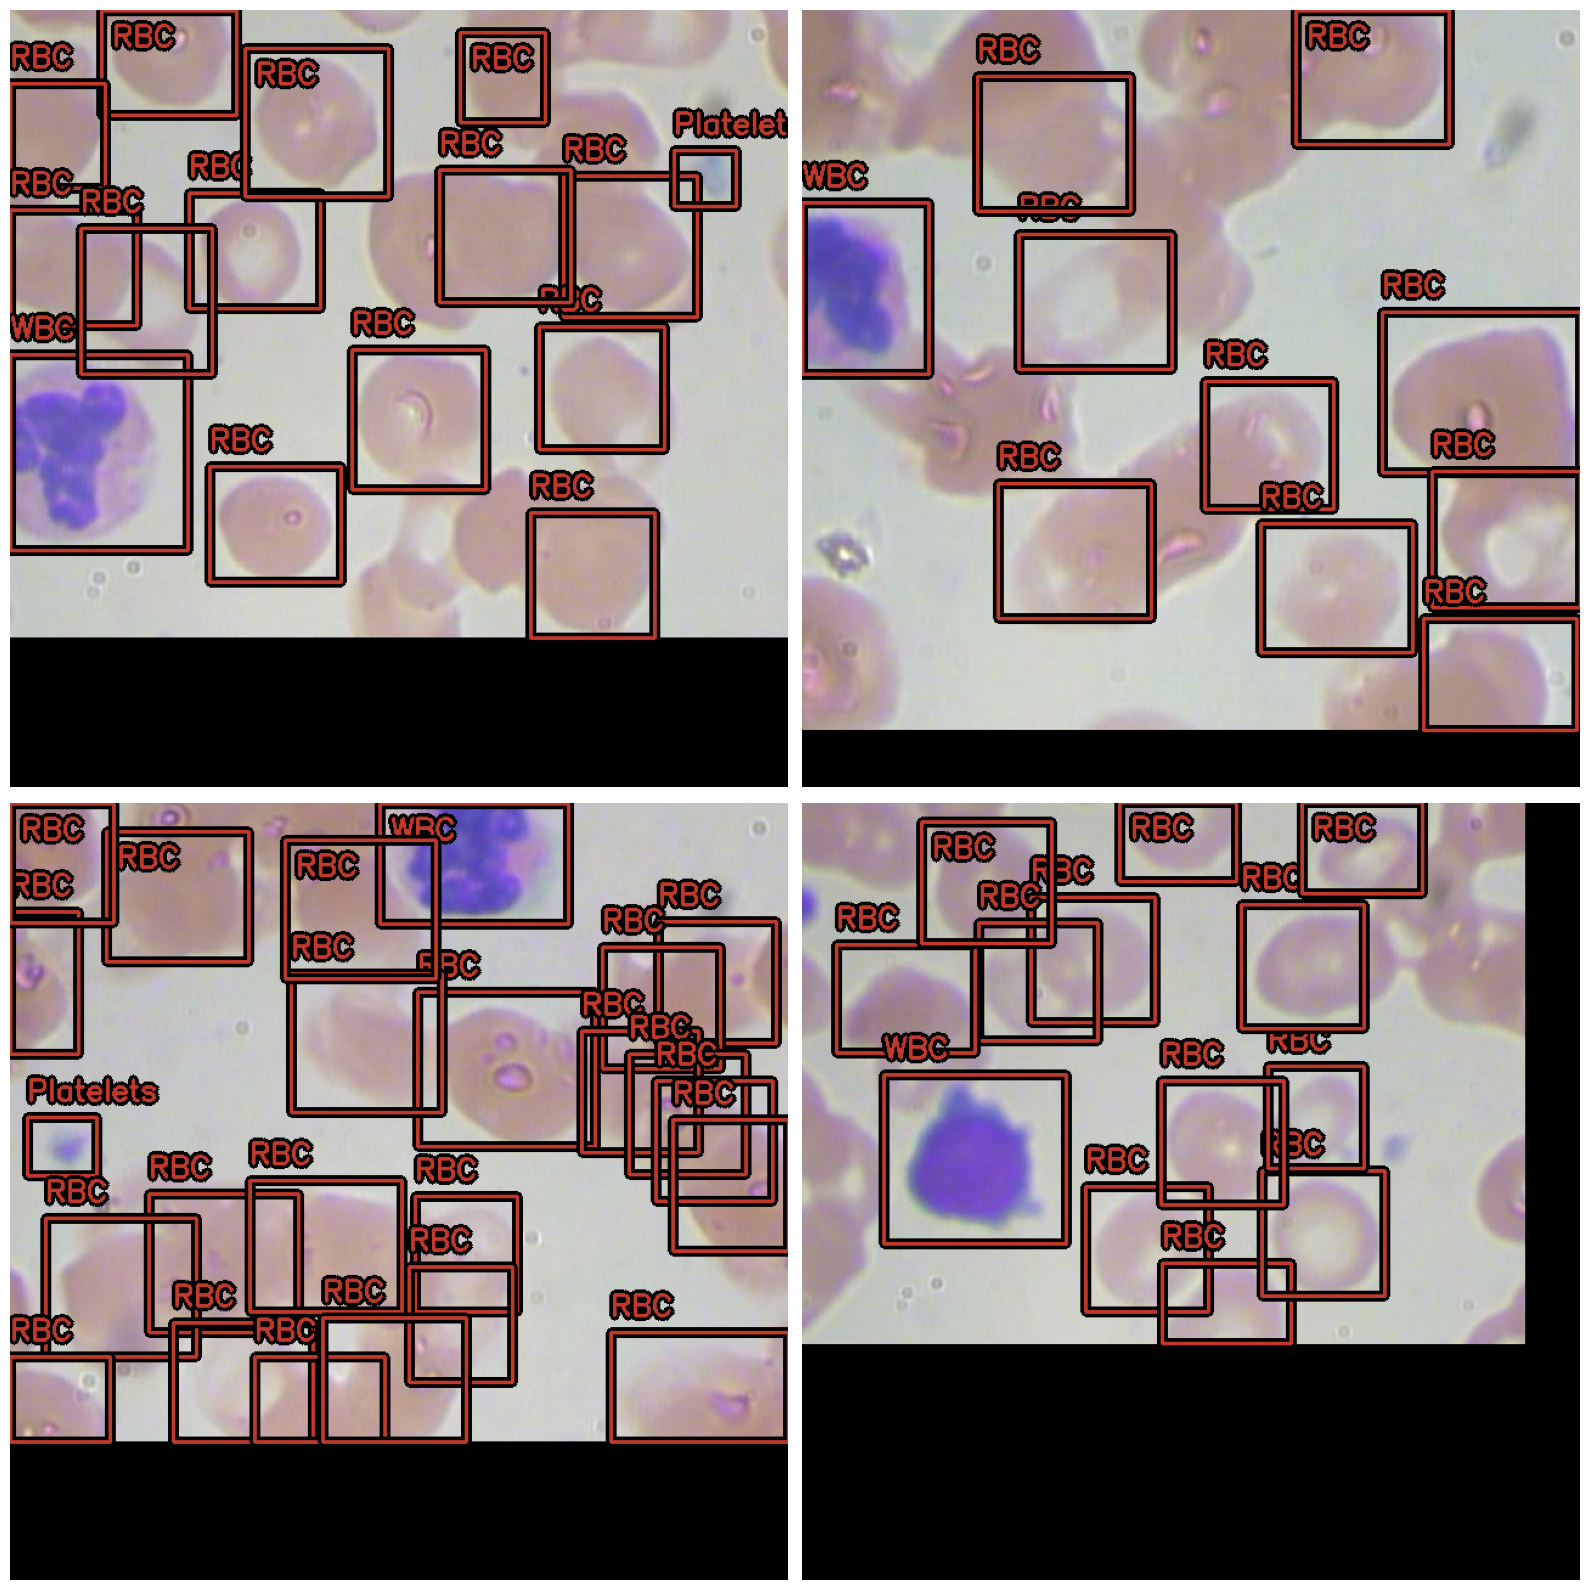

In [106]:
visualizerV8(valid_data, bounding_box_format="xyxy")


```
# This is formatted as code
@article{alam2019machine,
  title={Machine learning approach of automatic identification and counting of blood cells},
  author={Alam, Mohammad Mahmudul and Islam, Mohammad Tariqul},
  journal={Healthcare Technology Letters},
  volume={6},
  number={4},
  pages={103--108},
  year={2019},
  publisher={IET}
}

```

